# P3 - Dataset cleaning
Description des variables [ici](https://world.openfoodfacts.org/data/data-fields.txt)

## 1. Application idea
The idea here is to create an app that, from a given product, will : 
* Suggest similar products but organic (if it's possible) or with a better nutriscore.
* Display all the products nutritional information using spider charts (more complete than just the score).

## 2. Notebook initialisation and data loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

sns.set()
pd.set_option('display.max_columns', None)

In [5]:
def get_nutriscore_letter(score):
    if score < 0:
        return 'A'
    elif score < 3:
        return 'B'
    elif score < 11:
        return 'C'
    elif score < 19: 
        return 'D'
    else:
        return 'E'

In [6]:
data = pd.read_csv('data/data.csv', sep='\t')

## 3. Keeping french products only
The goal of our application is to suggest similar products. Moreover we want to use the french nutriscore as much as possible. That's why we decide here to **keep only the french products** for our study.

To achieve that, let's we have a look to the **countries** column and we can notice that each country can be present on at least 2 different forms that are case insensitive : 
* The country name itself : "France" or "france"
* The country code ("fr" for France) following another country name/code (separated by a colon) : "en:fr" for example.

So we use regular expressions to isolate these 2 cases and filter our countries to keep french products only.

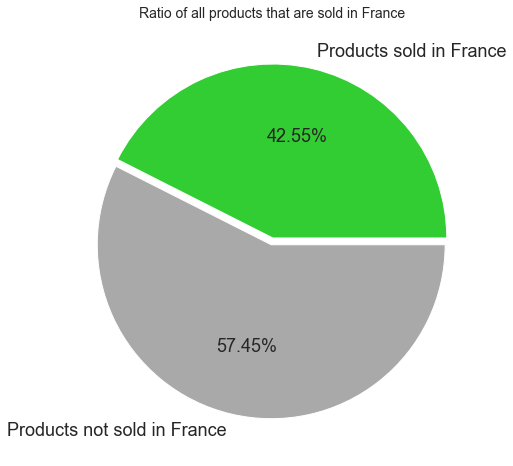

In [7]:
# Filtering data
data['sold_in_france'] = data['countries'].str.contains('(?:France)|(?::fr)', case=False, regex=True)

# Visualizing on a pie chart the ratio of products sold in France
total_french_products = len(data[data['sold_in_france'] == True])
total_not_french_products = len(data) - total_french_products

pie, ax = plt.subplots(figsize=[10,8])
plt.pie(x=[total_french_products, total_not_french_products], 
        autopct="%.2f%%", 
        labels=["Products sold in France", "Products not sold in France"], 
        colors=['limegreen', 'darkgrey'],
        explode=[0.02]*2,
        textprops={'size': 18})
plt.title("Ratio of all products that are sold in France", fontsize=14)

data_france = data[data['sold_in_france'] == True]

## 4. Pre-selecting our variables
We use the [variables liste](https://world.openfoodfacts.org/data/data-fields.txt) available on the OFF website.

To create our application, we would like to have these kinds of variables : 
* The **product name** 
* Various **nutritional information** to create our spider charts
* The **labels** to find an eventual organic label
* The **product french nutriscore** to compare products
* The **product categories** in order to understand which kind of product 
* Eventually a **product image** to make the display more 

### 4.1 Exploring the percentages of missing values for each column
Let's calculate the percentage of filled values for every variable of the dataset.

(0.0, 129.15)

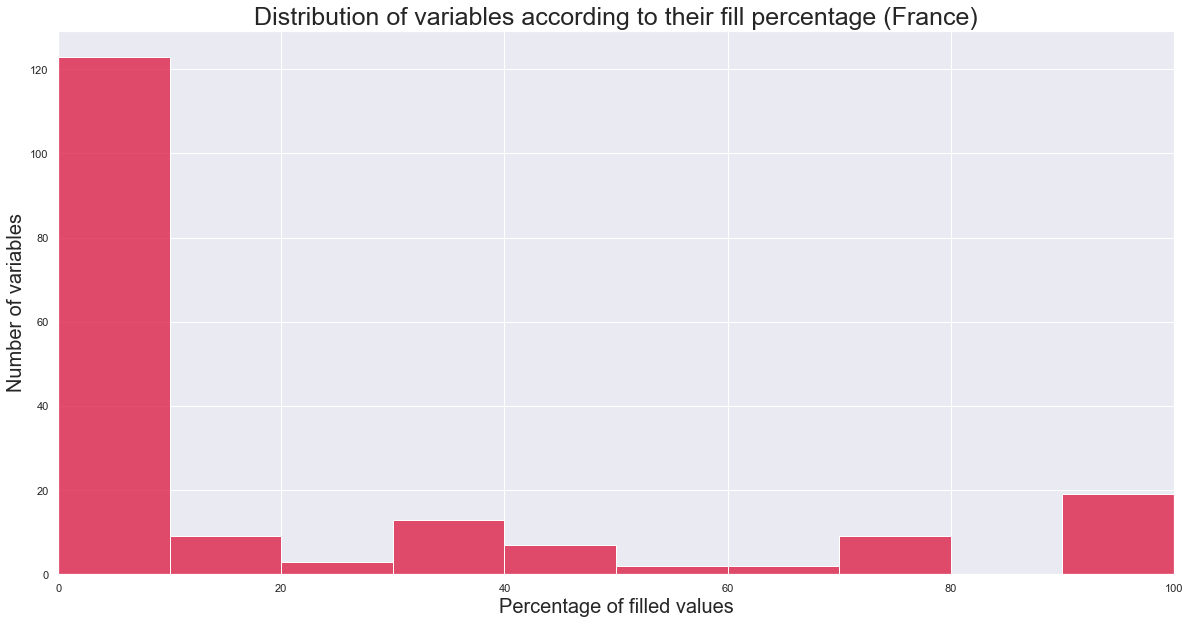

In [8]:
# Let's show the ditribution of our variables filling to get the best ones
filled_data = data_france.notnull().sum()
filled_data = filled_data * 100 / len(data_france)
filled_data = filled_data.sort_values(ascending=False)

# We plot the distribution of the filling percentage on a histogramm 
plt.figure(figsize=(20,10))
sns.histplot(filled_data, bins=10, color="crimson")
plt.title("Distribution of variables according to their fill percentage (France)", size=25)
plt.xlabel("Percentage of filled values", size=20)
plt.ylabel("Number of variables", size=20)
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,None])

**Conclusion** : most of the variables are less than 10% filled, so they are very uninteresting for our analysis.

Now let's have a look at the most filled variables of the dataset.

### 4.2 Exploring data filled at 80 - 100%

In [9]:
def get_variables_with_filling_percentage(filled_data, min=0, max=100):
    ''' Return the filled data with only a certain percentages of filling
    
        Parameters:
        filled_data (pd.series): the list of all the variables with one column containing their filling percentage
        min (int): the minimum filling percentage to keep (included)
        max (int): the maximum fulling percentage to keep (excluded except if = 100%)

        Returns:
        pd.series: the filtered variables
    '''
    # Avoid excluding 100% filled variables 
    if max == 100:
        max = 101
    plot_variables = filled_data.to_frame()
    plot_variables = plot_variables[(plot_variables[0] >= min) & (plot_variables[0] < max)]
    
    return plot_variables

def plot_variables_filling_percentage(filled_data, min=0, max=100):
    plot_variables = get_variables_with_filling_percentage(filled_data, min, max)
    
    # Plotting the results
    plot_variables.plot(kind='barh', 
                        xlim=(min,max),
                        figsize=(30,15),
                        fontsize=25)
    plt.gcf().suptitle("Variables with a filling percentage between " + str(min) + "% and " + str(max) + "%", fontsize=40)
    plt.gca().set_xlabel("Filling percentage (France data only)", fontsize=30)
    plt.gca().invert_yaxis()
    
    

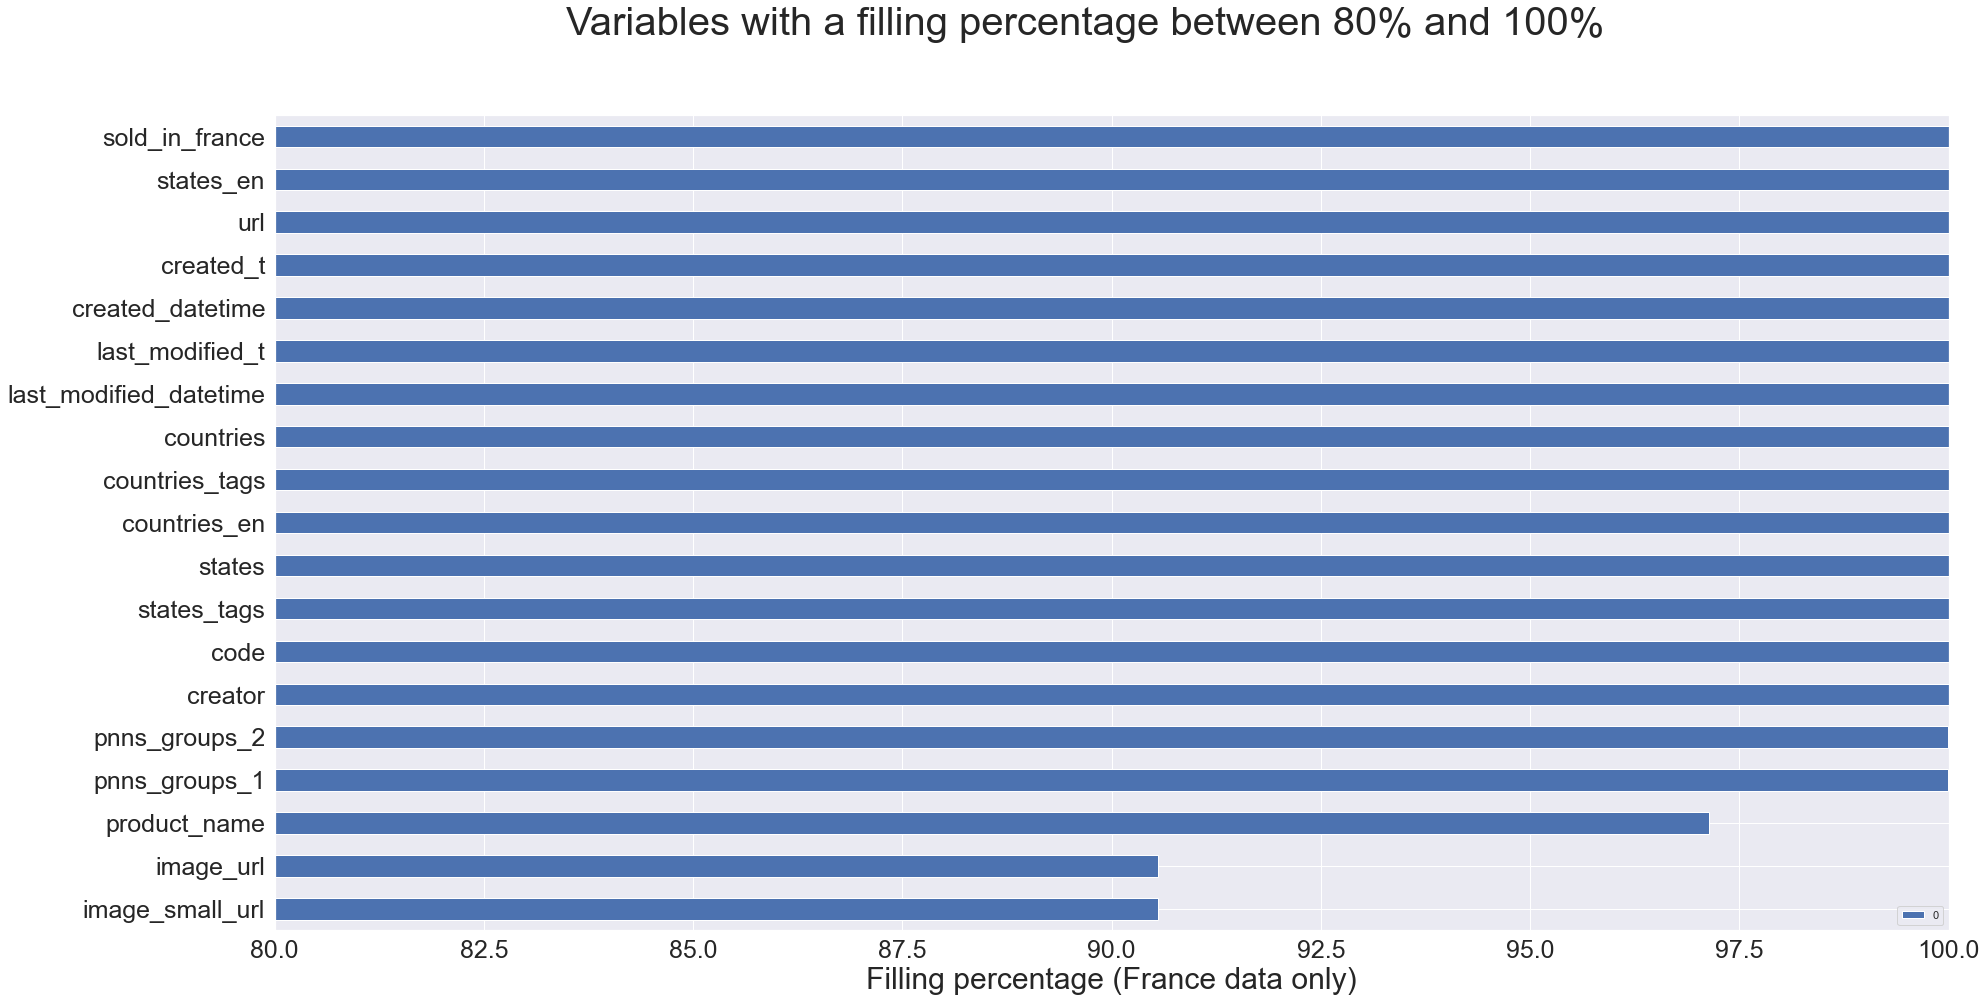

In [10]:
plot_variables_filling_percentage(filled_data, 80, 100)

We can notice several things : 
* all the variables that are 100% filled are mostly technicial variables of OpenFoodFacts (product code, datetimes, editors, ...)
* the **pnns** variables contains food categories created by the french government but it seems strange that they are as much filled. We are going to check it.
* we have, as we wanted to, a **product name**, an **url** and an **image_url** (which is as filled as the **image_small_url** that we can use to lightened the application results load.

Now let's check the values inside the pnns columns.

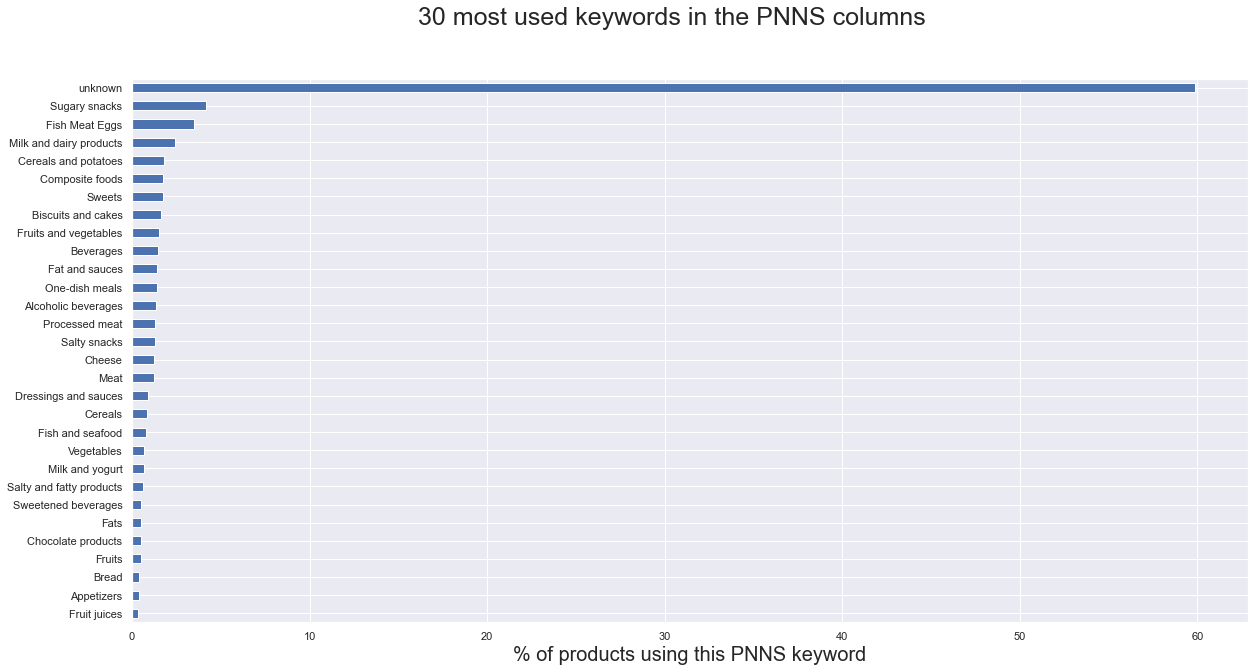

In [11]:
pnns = (pd.concat([data_france['pnns_groups_1'], data_france['pnns_groups_2']])).value_counts()

# The *2 factor is present because we concatenate 2 PNNS columns so we have twice the lenght of the initial DF
pnns = pnns * 100 / (len(data_france) * 2)

pnns_plot_size = 30
pnns[:pnns_plot_size].plot(kind='barh', 
                           figsize=(20,10))
plt.gcf().suptitle(str(pnns_plot_size) + " most used keywords in the PNNS columns", fontsize=25)
plt.gca().set_xlabel("% of products using this PNNS keyword", fontsize=20)
plt.gca().invert_yaxis()

We notice that the "**unknown**" keyword it used 80% of the time. So, in fact, the PNNS variables are 80% empty, so we are going to replace the "unknown" values by NaN values for the rest of the analysis.

In [12]:
data_france.loc[data_france['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan
data_france.loc[data_france['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

# The average filling percentage of PNNS columns should be around 40% now
100*(data_france['pnns_groups_1'].notnull().sum() + data_france['pnns_groups_2'].notnull().sum()) / (2 * len(data_france))

C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


40.14132699549512

#### Conclusion
Among the varialbes filled at 80-100% we will keep : 
* url
* product_name
* image_small_url

### 4.3 Exploring the data filled at 60 - 80%

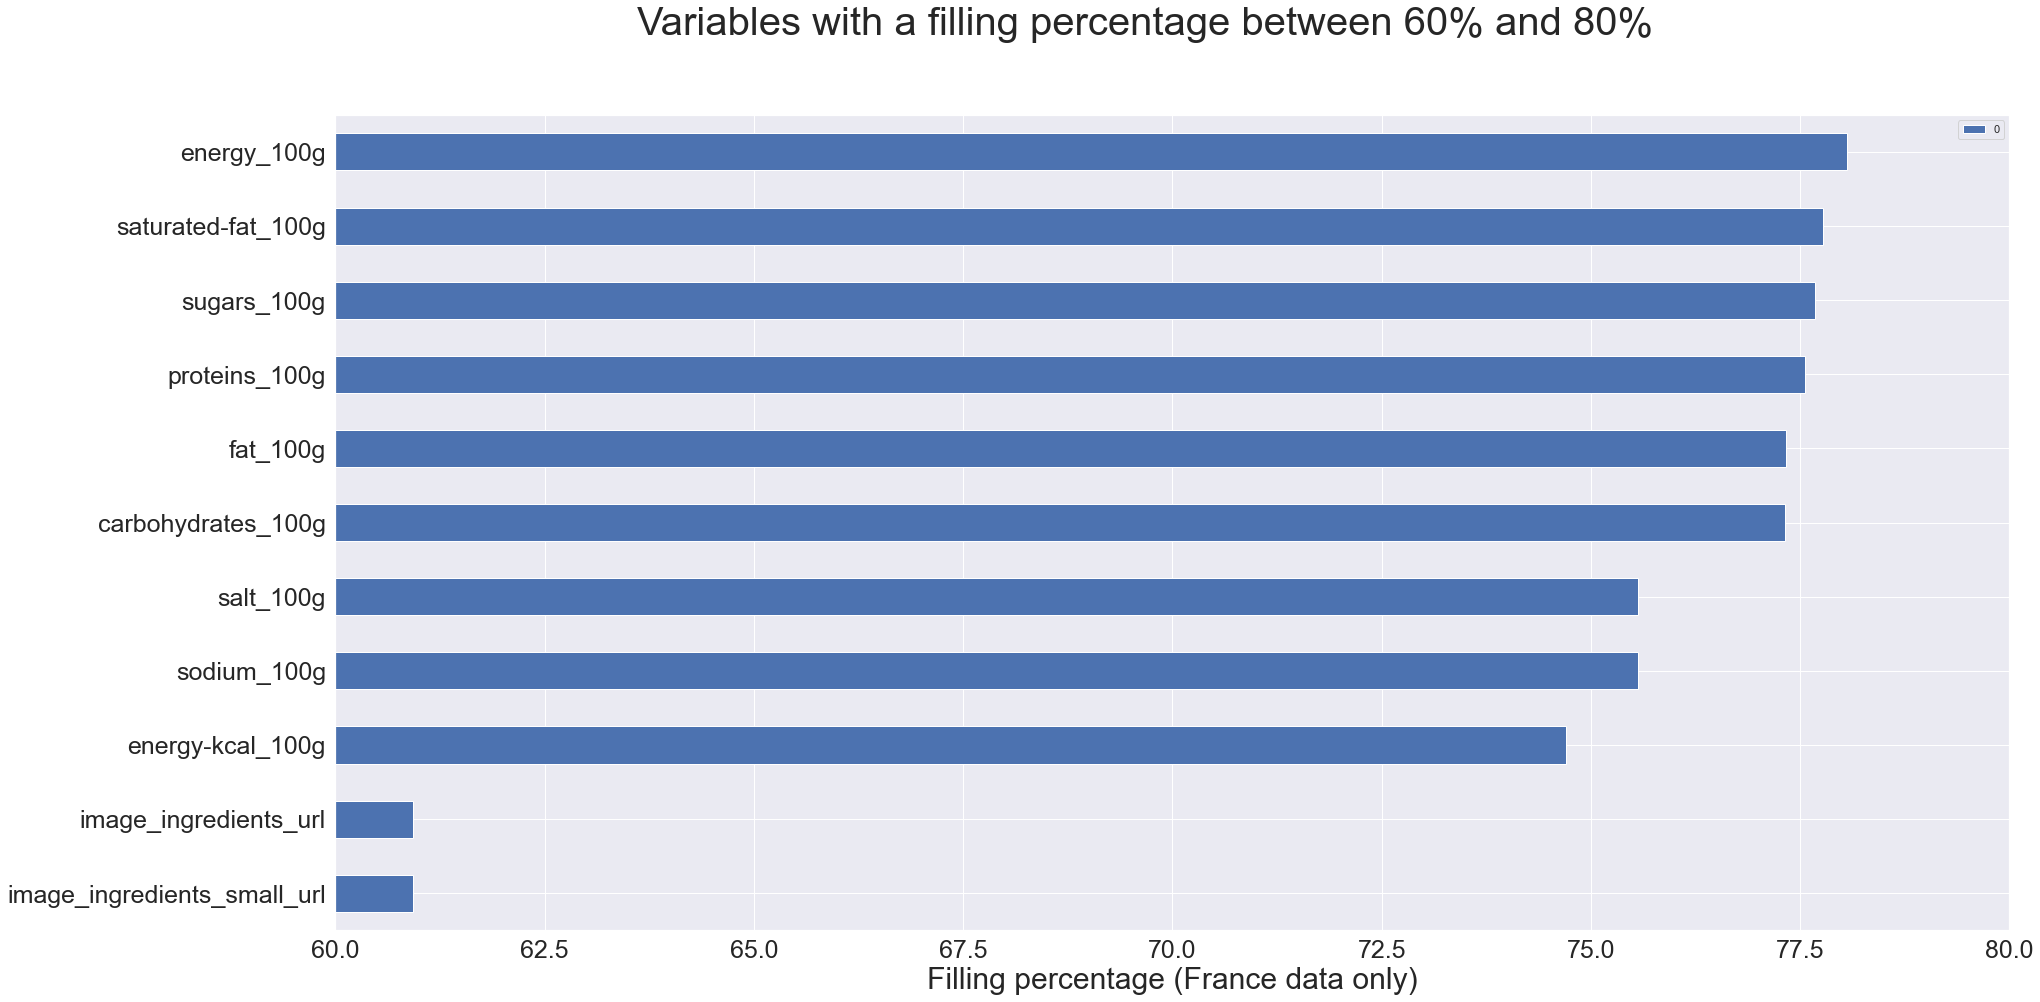

In [13]:
plot_variables_filling_percentage(filled_data, 60, 80)

We can here make out 2 types of variables : 
* the product ingredient image url, which are not useful for our application
* many nutritional information that can be used to display our nutritional spider charts

But the question is : **do all the nutritional informations are present here** ? We can notice that they all ends with "**_100g**" so let's find all variables with this pattern that are not present in the list above.

In [14]:
best_variables = filled_data.to_frame()
var_60_100 = get_variables_with_filling_percentage(filled_data, 60, 100)
best_variables[(best_variables.index.isin(var_60_100.index.values) == False) 
               & (best_variables.index.str.endswith('_100g'))].sort_values(by=0, ascending=False)

0
nutrition-score-fr_100g                  34.929305
fiber_100g                               17.121211
energy-kj_100g                            9.164081
carbon-footprint-from-meat-or-fish_100g   1.462206
fruits-vegetables-nuts-estimate_100g      1.310174
...                                            ...
-erucic-acid_100g                         0.000127
-nervonic-acid_100g                       0.000127
water-hardness_100g                       0.000000
-dihomo-gamma-linolenic-acid_100g         0.000000
-elaidic-acid_100g                        0.000000

[102 rows x 1 columns]

We note here that they are **102 extra nutritional information** in the dataset. But we also notice that only 3 of them are above 1.5% of filling. The three remaining are : 
* the **french nutriscore** which is a very important variable for us
* the **fibers for 100g** of product, which can also be important, but is not very reliable because of its low 17% of filling
* the "energy for 100g" in kilo-joules which is not useful for us because we already have this information in the kcal unit, which is the unit generally displayed on the products packaging. Moreover, this column is only 9% filled, against 75% for the column in kcal.

### 4.4 Exploring the data filled at 30 - 60%

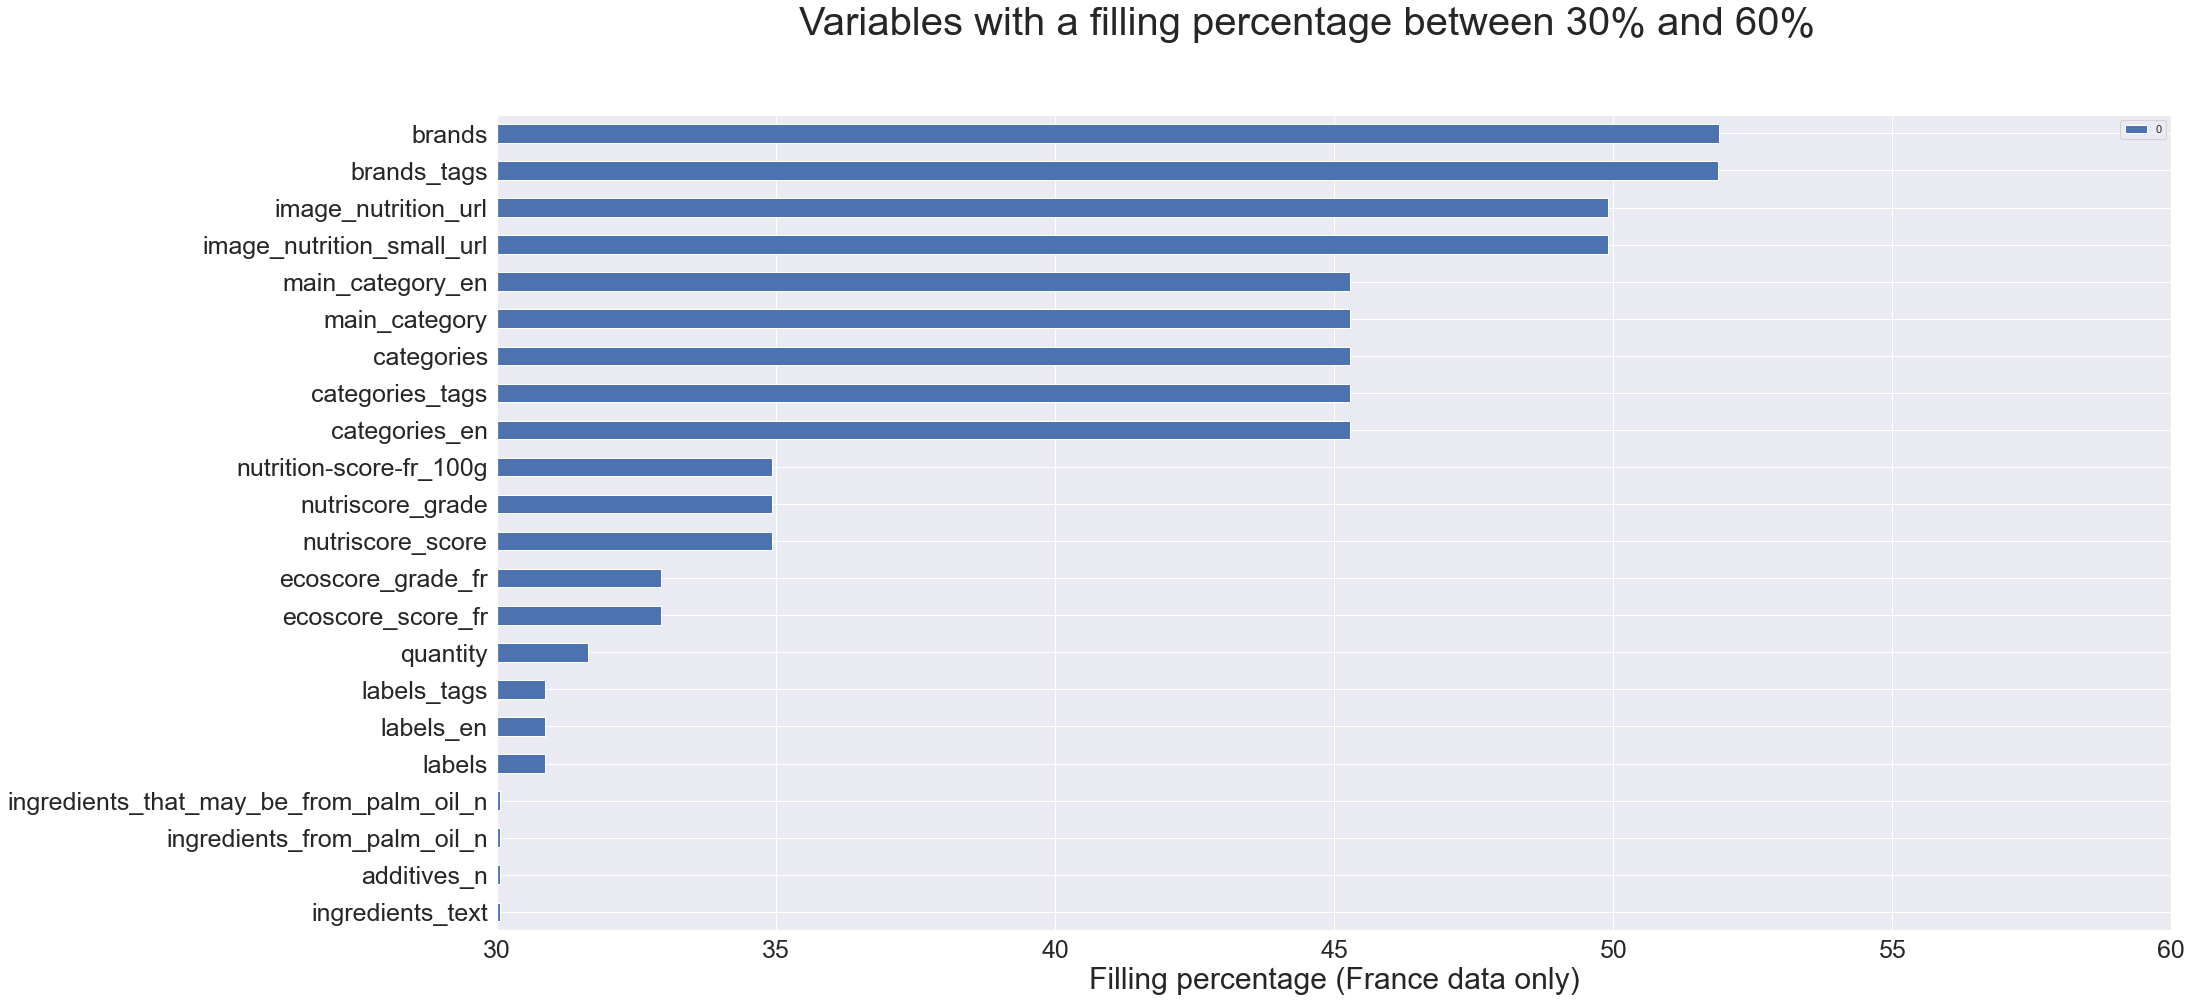

In [15]:
plot_variables_filling_percentage(filled_data, 30, 60)

We have many things to raise on this part : 
* there are a **main_category**, a **categories** and a **categories_tags** variables that can be really helpful if the *pnns* variables are not filled enough
* we find again the **nutrition-score-fr_100g** we met before, along with a **nutriscore_score** and a **nutriscore_grade** that should be linked
* the **labels** in order to find out, for example, some organic products
* somes variables can inform us about the presence of **ingredients from palm oil** that we could use to discriminate 2 products (find out which one is more healthy)

### 4.5 Exploring the data filled at 10 - 30%

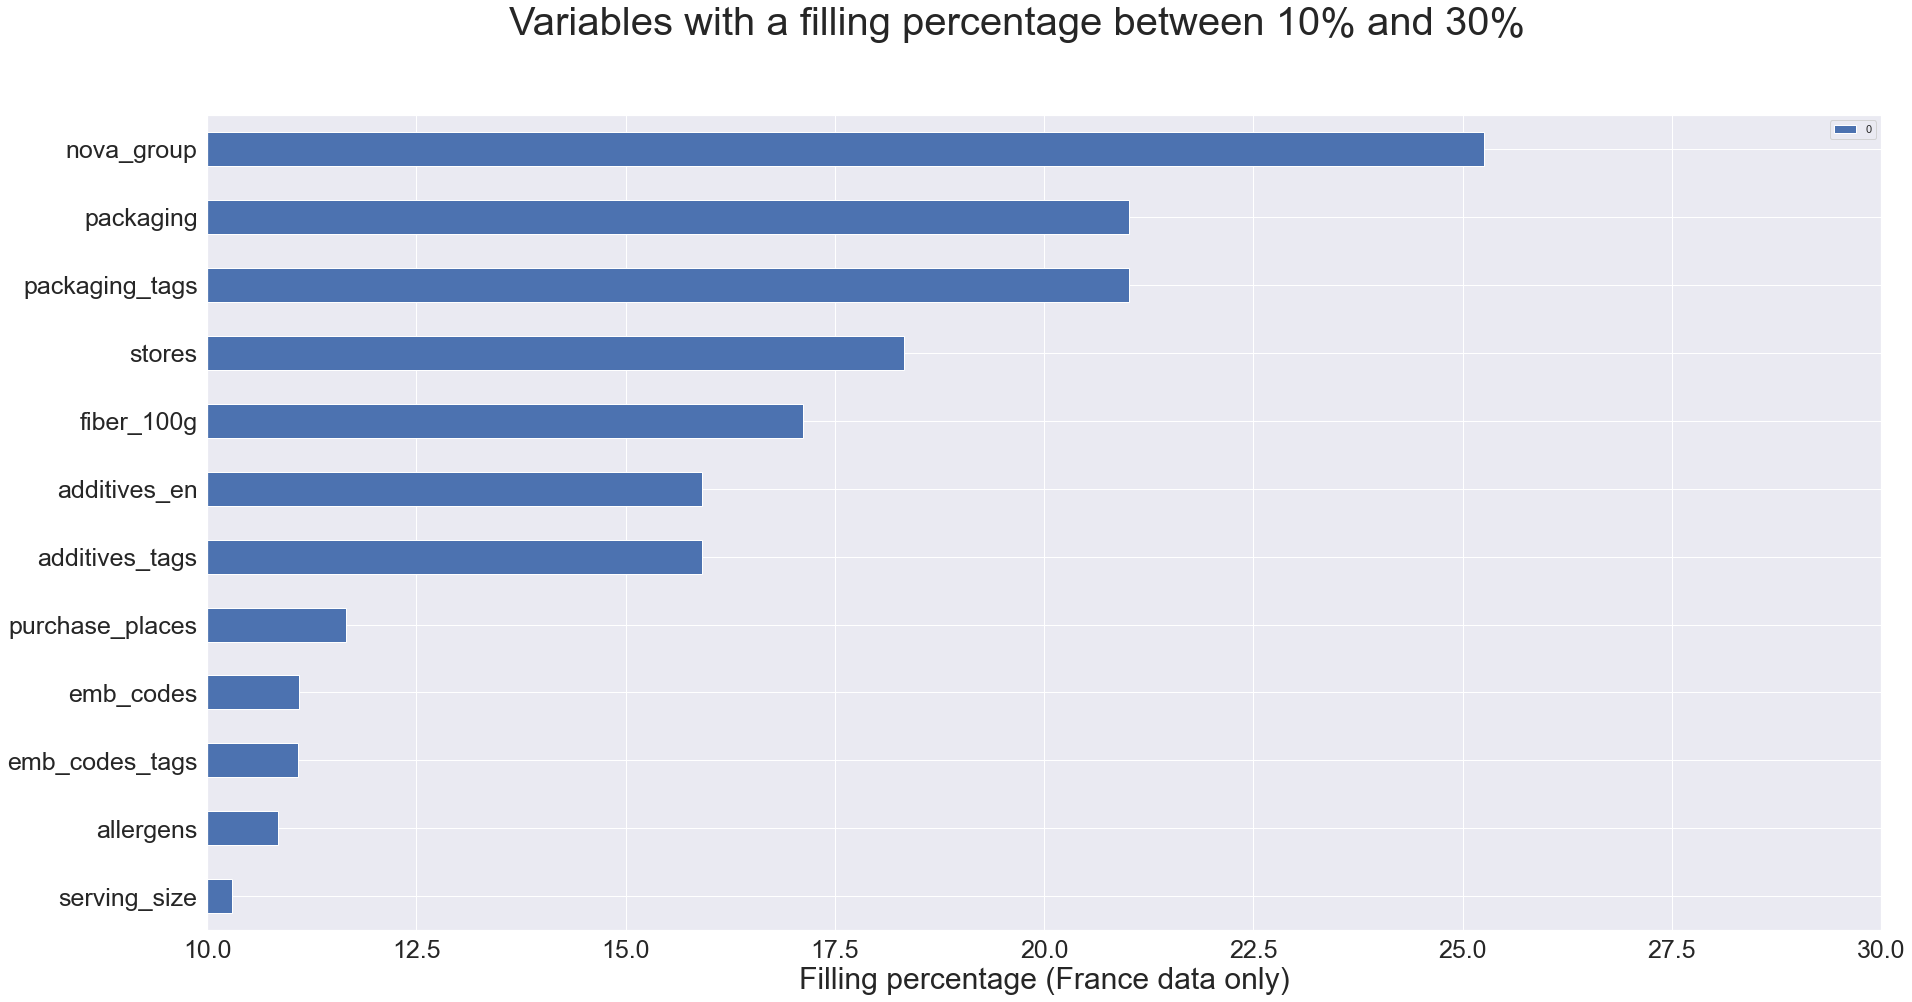

In [16]:
plot_variables_filling_percentage(filled_data, 10, 30)

Even if these columns are not filled enough, one of them is interesting and could be helpful for the rest of our analysis : 
* the **fiber_100** that we will include in our spider chart only if it is provided

### 4.6 Final list of the pre-selected variables
We can 

In [17]:
display_variables = ['url', 'product_name', 'image_small_url']
category_variables = ['main_category', 'categories', 'categories_tags']
label_variables = ['labels', 'labels_tags']
nutriscore_variables = ['nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade']
calculation_variables = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
                        'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'energy-kcal_100g',
                        'ingredients_from_palm_oil_n', 'fiber_100g']

## 5. Analysing our pre-selected variables
In this part, we will try to answer these questions :
* **Are all the 3 "nutriscore" columns essential** or can we reduce them to keep only one of them ?
* Same question for the categories and labels ?
* Can we **determine the percentage of fibers by using the other columns** ?

### 5.1 Comparing nutritional score indicators

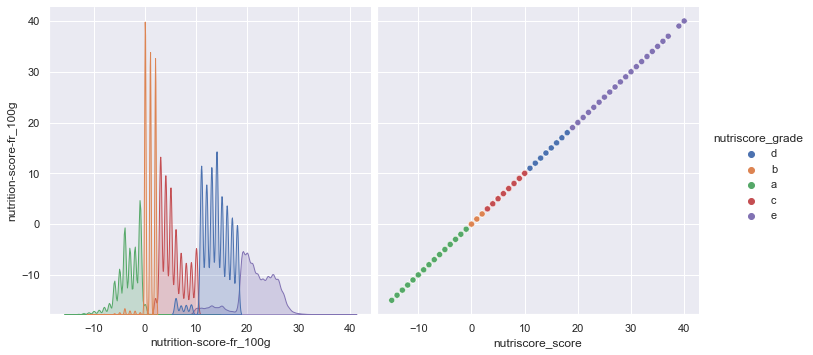

In [18]:
nutriscore_data = data_france[nutriscore_variables]
plt.title
sns.pairplot(nutriscore_data, 
             x_vars=["nutrition-score-fr_100g", "nutriscore_score"],
             y_vars=["nutrition-score-fr_100g"],
             hue='nutriscore_grade', 
             height=5)

In [19]:
print("Comparing these 3 columns filling percentages : ")
filled_data[filled_data.index.isin(nutriscore_variables)]

Comparing these 3 columns filling percentages : 


nutrition-score-fr_100g    34.929305
nutriscore_grade           34.928922
nutriscore_score           34.928922
dtype: float64

These charts give us many informations.
* The **nutriscore_score and and nutrition-score-fr_100g are the same**. We notice a perfect straight line between both, with a 45° angle and a 0 origin value. It means that our 2 columns have the same values.


* We also notice the different colors on these straight lines that **confirm the french nutriscore grade slices** : 
 * **Grade A** : from -15 to -1
 * **Grade B** : from 0 to 2
 * **Grace C** : from 3 to 10
 * **Grade D** : from 11 to 18
 * **Grade E** : from 19 to 40
 
 
* The 2 histograms shows the **nutriscore_grade errors** : the different colors should be perfectly separated according to the slices above, but we can see that they are not.


**CONCLUSION** : we can keep only one of these 3 columns, and **we will keep the nutrition-score-fr_100g** as it a little more filled. We will reassign a nutriscore-grade using the official nutriscore slices.

But before removing the *nutriscore_score* columns, let's check if they are some products for which this column is filled and not the *nutrition-score-fr_100g* : 

In [20]:
data_france[(data_france['nutriscore_score'].notnull()) & (data_france['nutrition-score-fr_100g'].isnull())]

Empty DataFrame
Columns: [code, url, creator, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, abbreviated_product_name, generic_name, quantity, packaging, packaging_tags, packaging_text, brands, brands_tags, categories, categories_tags, categories_en, origins, origins_tags, origins_en, manufacturing_places, manufacturing_places_tags, labels, labels_tags, labels_en, emb_codes, emb_codes_tags, first_packaging_code_geo, cities, cities_tags, purchase_places, stores, countries, countries_tags, countries_en, ingredients_text, allergens, allergens_en, traces, traces_tags, traces_en, serving_size, serving_quantity, no_nutriments, additives_n, additives, additives_tags, additives_en, ingredients_from_palm_oil_n, ingredients_from_palm_oil, ingredients_from_palm_oil_tags, ingredients_that_may_be_from_palm_oil_n, ingredients_that_may_be_from_palm_oil, ingredients_that_may_be_from_palm_oil_tags, nutriscore_score, nutriscore_grade, nova_group, pnns_groups_1, pnns_groups_2, states, states_tags, states_en, brand_owner, ecoscore_score_fr, ecoscore_grade_fr, main_category, main_category_en, image_url, image_small_url, image_ingredients_url, image_ingredients_small_url, image_nutrition_url, image_nutrition_small_url, energy-kj_100g, energy-kcal_100g, energy_100g, energy-from-fat_100g, fat_100g, saturated-fat_100g, -butyric-acid_100g, -caproic-acid_100g, -caprylic-acid_100g, -capric-acid_100g, -lauric-acid_100g, -myristic-acid_100g, -palmitic-acid_100g, -stearic-acid_100g, -arachidic-acid_100g, -behenic-acid_100g, -lignoceric-acid_100g, -cerotic-acid_100g, -montanic-acid_100g, -melissic-acid_100g, monounsaturated-fat_100g, polyunsaturated-fat_100g, omega-3-fat_100g, -alpha-linolenic-acid_100g, -eicosapentaenoic-acid_100g, ...]
Index: []

Our choice is good, and there is no need to merge the 2 columns.

### 5.2 Selecting a category column
We pre-selected many category columns, now we would like to explore them and see if one of them seems better than the others.

First of let's compare their filling percentages : we notice that the **categories** are all filled ad approximately 45% which is pretty good. 

Now let's have a look at what's inside these columns : 

In [21]:
categories_data = data_france[category_variables].dropna(how="all")
categories_data

main_category  \
5                         en:mustards   
6                              fr:xsf   
15                   fr:pate-d-amende   
16       en:seasoned-shredded-carrots   
25                    en:coconut-pies   
...                               ...   
1844198               en:gingerbreads   
1844199         en:ground-beef-steaks   
1844202             en:sweet-fritters   
1844205         en:ground-beef-steaks   
1844212                 en:toothpaste   

                                                categories  \
5                  Epicerie, Condiments, Sauces, Moutardes   
6                                                      Xsf   
15                                           Pâte d'amende   
16       Plats préparés, Légumes préparés, Carottes râp...   
25        Tartes, Tartes sucrées, Tartes à la noix de coco   
...                                                    ...   
1844198                Biscuits et gâteaux, Pains d'épices   
1844199  Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...   
1844202             Snacks, Snacks sucrés, Beignets sucrés   
1844205  Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...   
1844212   Non food products, Open Beauty Facts, Toothpaste   

                                           categories_tags  
5         en:groceries,en:condiments,en:sauces,en:mustards  
6                                                   fr:xsf  
15                                        fr:pate-d-amende  
16       en:meals,en:prepared-vegetables,en:grated-carr...  
25                   en:pies,en:sweet-pies,en:coconut-pies  
...                                                    ...  
1844198              en:biscuits-and-cakes,en:gingerbreads  
1844199  en:meats,en:beef,en:steaks,en:beef-steaks,en:g...  
1844202        en:snacks,en:sweet-snacks,en:sweet-fritters  
1844205  en:meats,en:beef,en:steaks,en:beef-steaks,en:g...  
1844212  en:non-food-products,en:open-beauty-facts,en:t...  

[355274 rows x 3 columns]

In [22]:
split_tags_count = (categories_data['categories_tags'].str.split(',', expand=True).stack().value_counts()).to_frame()
split_tags_count = 100 * split_tags_count / len(data_france)
split_tags_count.columns = ['% of products']
split_tags_count

% of products
en:plant-based-foods-and-beverages      12.833103
en:plant-based-foods                    11.068491
en:snacks                                6.572279
en:meats                                 5.793642
en:sweet-snacks                          5.570246
...                                           ...
fr:sans-ogm                              0.000127
fr:sang-de-porc                          0.000127
en:maca                                  0.000127
fr:soupe-veloute                         0.000127
fr:coteaux-du-tricastin                  0.000127

[19212 rows x 1 columns]

The use of each keyword is very various, between 12% and 0.0001%. We now would like to know how they are distributed

Text(0, 0.5, 'Number of keywords')

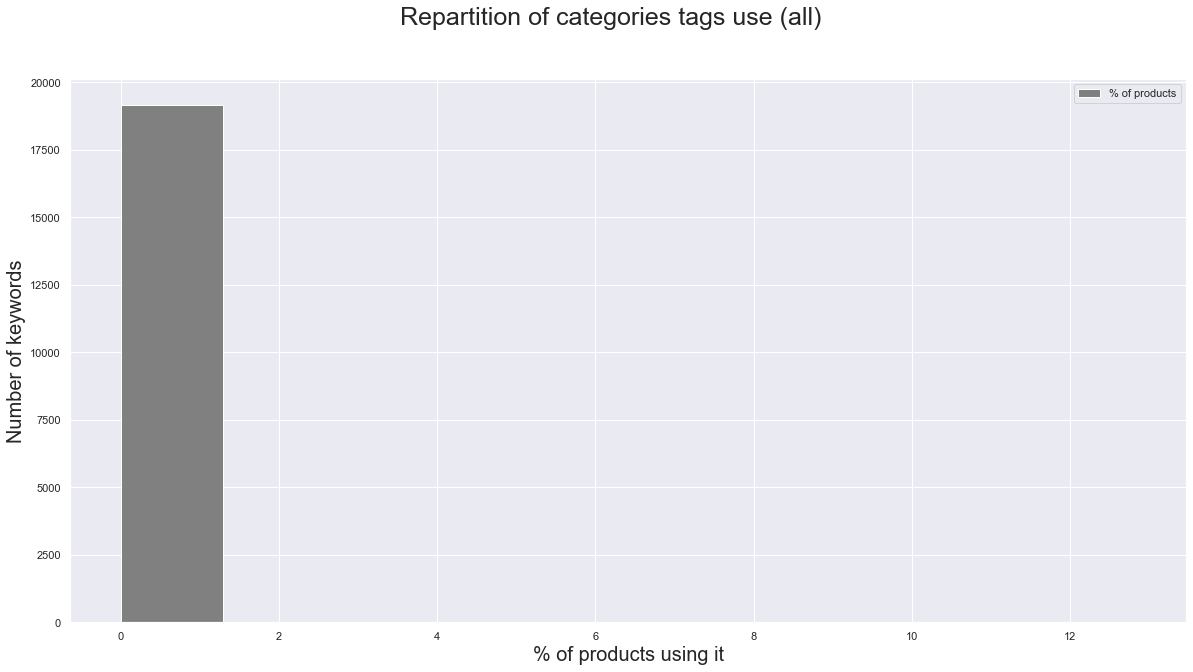

In [23]:
split_tags_count.plot(kind='hist', figsize=(20,10), color="grey")
plt.gcf().suptitle("Repartition of categories tags use (all)", fontsize=25)
plt.gca().set_xlabel("% of products using it", fontsize=20)
plt.gca().set_ylabel("Number of keywords", fontsize=20)

We can't see anything here, except that almost all keywords are used less than 1,5%. Let's try to create to histograms : 

Text(0, 0.5, 'Number of keywords')

<Figure size 1440x1440 with 0 Axes>

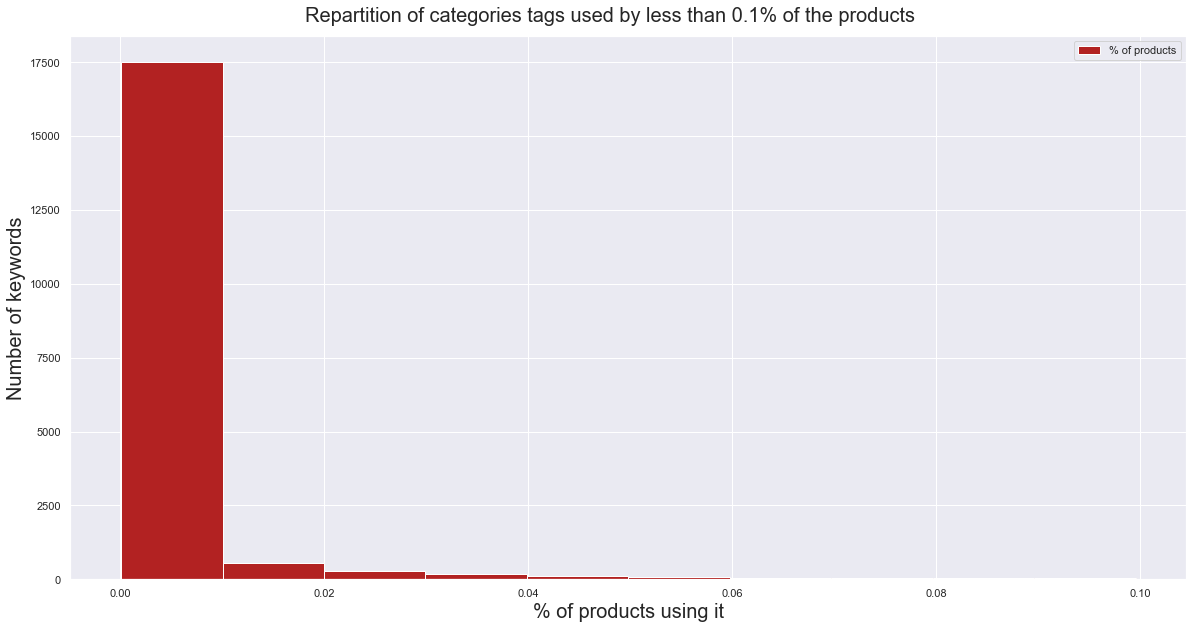

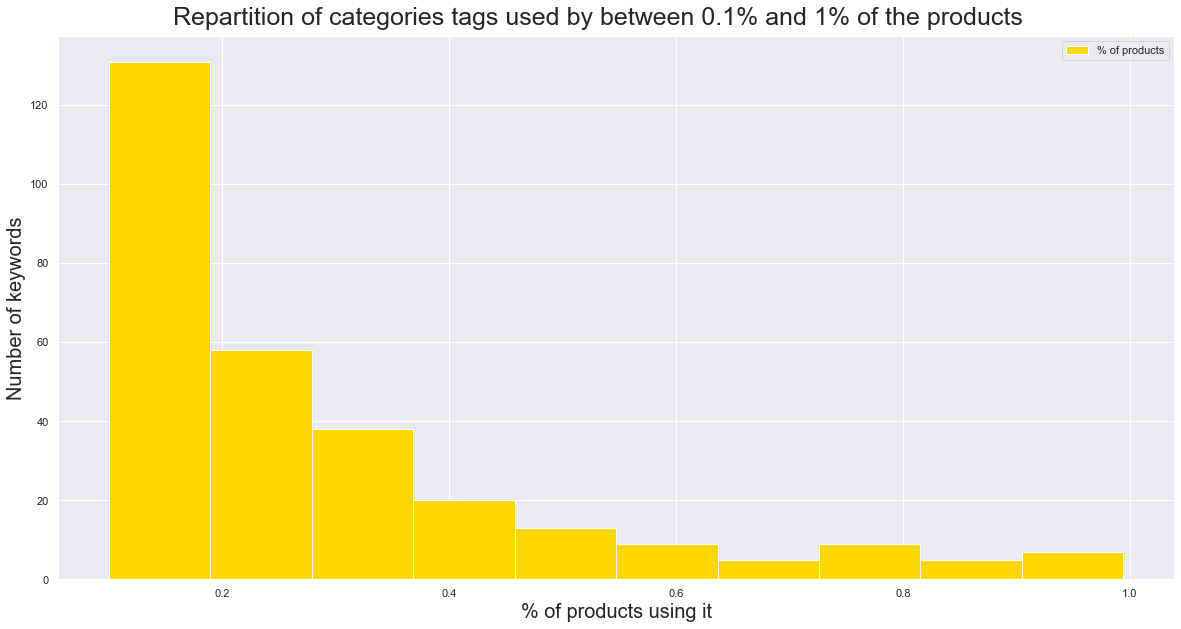

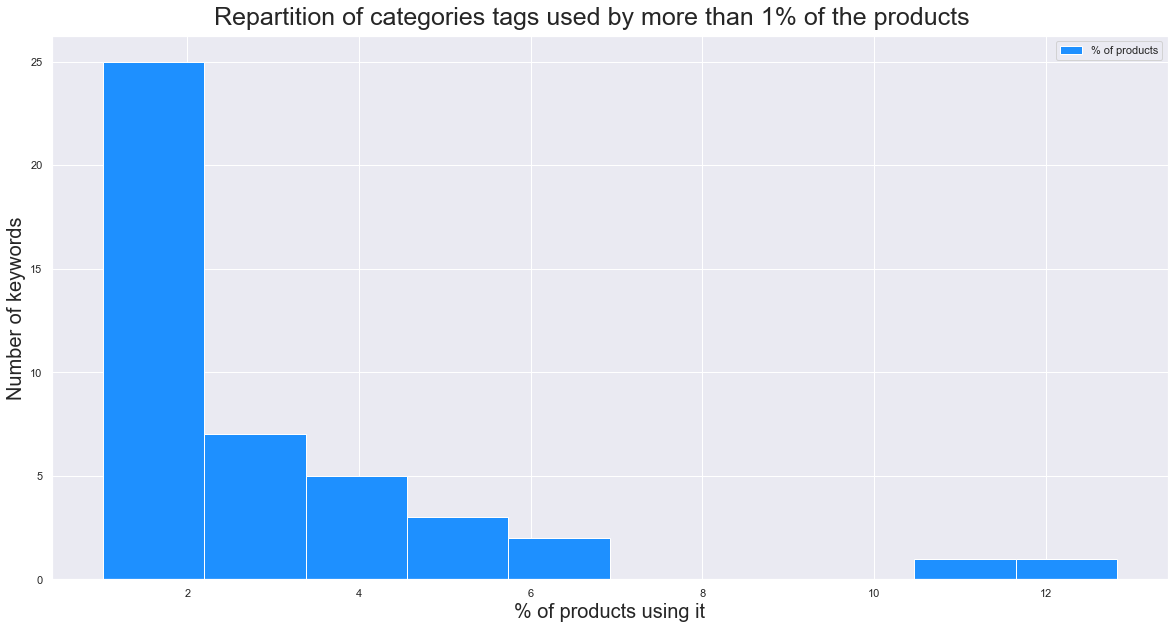

In [24]:
plt.figure(figsize=(20,20))

total = str(len(split_tags_count))

# Tags used by less than 0.1% of products
subtotal = str(len(split_tags_count[split_tags_count['% of products'] <= 0.1]))
split_tags_count[split_tags_count['% of products'] <= 0.1].plot(kind='hist', figsize=(20,10), color="firebrick")
plt.gcf().suptitle("Repartition of categories tags used by less than 0.1% of the products", 
                   fontsize=20, 
                   y=0.92)
plt.gca().set_xlabel("% of products using it", fontsize=20)
plt.gca().set_ylabel("Number of keywords", fontsize=20)
split_tags_count[(split_tags_count['% of products'] > 0.1) & (split_tags_count['% of products'] <= 1)].plot(kind='hist', 
                                                                                                            figsize=(20,10),
                                                                                                            color="gold")
plt.gcf().suptitle("Repartition of categories tags used by between 0.1% and 1% of the products", fontsize=25, y=0.92)
plt.gca().set_xlabel("% of products using it", fontsize=20)
plt.gca().set_ylabel("Number of keywords", fontsize=20)

split_tags_count[split_tags_count['% of products'] > 1].plot(kind='hist', figsize=(20,10), color="dodgerblue")
plt.gcf().suptitle("Repartition of categories tags used by more than 1% of the products", fontsize=25, y=0.92)
plt.gca().set_xlabel("% of products using it", fontsize=20)
plt.gca().set_ylabel("Number of keywords", fontsize=20)

Text(0, 0.5, '% of tags')

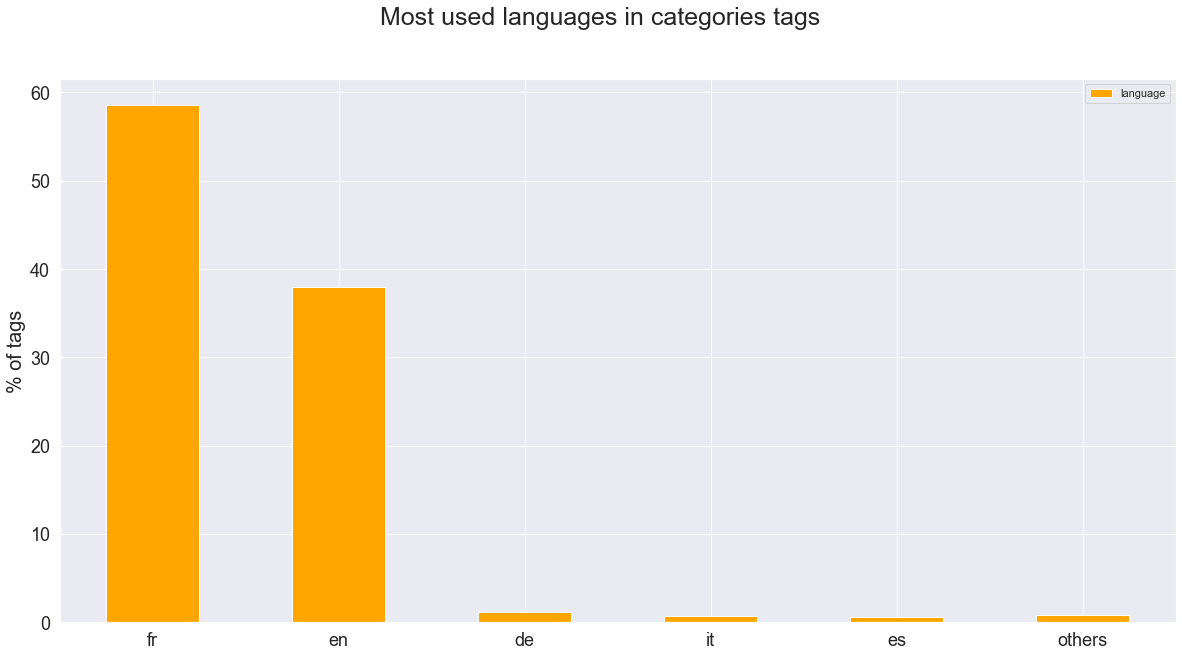

In [25]:
def extract_country_code(tag):
    tag_parts = tag.split(':')
    if len(tag_parts) > 1 and re.match('^[a-z]{2}$', tag_parts[0]):
        return tag_parts[0]
    return math.nan

# Extracting the language from the first element of each tag
split_tags_count['language'] = split_tags_count.index
split_tags_count['language'] = split_tags_count['language'].map(extract_country_code)

# Counting and grouping all the less-representated languages into a "other languages" category
REST_OFFSET = 100
tags_languages_count = (split_tags_count['language'].value_counts()).to_frame()
show_languages = tags_languages_count[tags_languages_count['language'] > REST_OFFSET].copy()
show_languages.loc['others'] = tags_languages_count[tags_languages_count <= REST_OFFSET].sum()
show_languages = 100 * show_languages / len(split_tags_count)

# Finally plotting the result
show_languages.plot(kind='bar', figsize=(20,10), fontsize=18, rot=0, color="orange")
plt.gcf().suptitle("Most used languages in categories tags", fontsize=25)
plt.gca().set_ylabel("% of tags", fontsize=20)

### 5.3 Looking for organic label
For organic labels, we are going to add a boolean column at True if the labels contains "organic" or "bio" (to match both french and english organic names)

<ipython-input-26-4c3fb419db58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_france['organic'] = data_france['labels'].str.contains('(?:organic)|(?:bio)', case=False, regex=True)


([<matplotlib.patches.Wedge at 0x1cf23a935e0>,
 [Text(1.0471416644169174, 0.3973592010287015, 'Organic'),
  Text(0.26497436108487427, 1.088204295142995, 'Non organic'),
  Text(-0.6338158530275229, -0.9234053630183192, 'N/A')],
 [Text(0.5796677070879365, 0.21996670056945972, '11.54%'),
  Text(0.14668223560055538, 0.6023988062398723, '19.31%'),
  Text(-0.35086234721166437, -0.5111708259565695, '69.15%')])

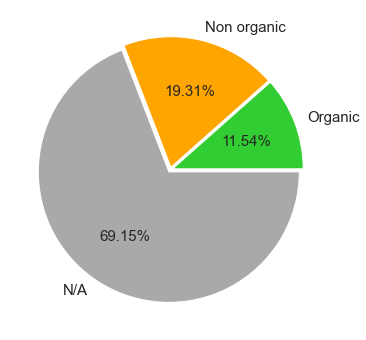

In [26]:
data_france['organic'] = data_france['labels'].str.contains('(?:organic)|(?:bio)', case=False, regex=True)
total_organic_products = len(data_france[data_france['organic'] == True])
total_non_organic_products = len(data_france[data_france['organic'] == False])
total_null_organic_products = len(data_france[data_france['organic'].isnull() == True])

plt.figure(figsize=(6,6))
plt.pie([total_organic_products, total_non_organic_products, total_null_organic_products],
        autopct="%.2f%%", 
        labels=["Organic", "Non organic", "N/A"], 
        colors=['limegreen', 'orange', 'darkgrey'],
        explode=[0.02]*3,
        textprops={'size': 15})

### 5.4 Comparing energy columns

In [27]:
energy_data = data_france[['energy_100g', 'energy-kcal_100g']].copy()
energy_data['ratio'] = energy_data['energy_100g'] / energy_data['energy-kcal_100g']
energy_data[(energy_data['energy_100g'].notnull()) & (energy_data['energy-kcal_100g'].notnull())]

ZeroDivisionError: float division by zero

These 2 columns seem to be linked by a fixed ratio around 4.18.

We are going to merge them into the *energy-kcal_100g* column using the mean ratio of the entire set, then we'll keep only this column.

In [ ]:
ratio = energy_data[(energy_data['ratio'].notnull()) & (energy_data['ratio'] != np.inf)]['ratio'].mean()
data_france.loc[(data_france['energy_100g'].notnull()) & (data_france['energy-kcal_100g'].isnull()), 'energy-kcal_100g'] = data_france['energy_100g'] / ratio

### 5.5 Checking ingredient from palm oil column
We decide not to keep this column because it contains some numeric values but we have no idea what they represent. It can be the number of ingredients using palm oil in the product, but as we are not sure, and this column is not very filled, we remove it.

In [ ]:
data_france['ingredients_from_palm_oil_n'].unique()

## 6. Treating aberrant and missing values

### 6.1 Filtering data columns
First of all, now we have selected our final columns, we can filter the dataframe :

In [ ]:
final_columns = ['url',
                 'product_name',
                 'image_small_url',
                 'categories_tags',
                 'organic',
                 'nutrition-score-fr_100g',
                 'saturated-fat_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fat_100g',
                 'carbohydrates_100g',
                 'salt_100g',
                 'sodium_100g',
                 'energy-kcal_100g',
                 'fiber_100g']
data_france = data_france.filter(final_columns, axis=1)

### 6.2 Removing completely empty lines

In [ ]:
# We removed the column "url" that is 100% filled
data_france = data_france.dropna(how="all", subset=[
     'product_name',
     'image_small_url',
     'categories_tags',
     'organic',
     'nutrition-score-fr_100g',
     'saturated-fat_100g',
     'sugars_100g',
     'proteins_100g',
     'fat_100g',
     'carbohydrates_100g',
     'salt_100g',
     'sodium_100g',
     'energy-kcal_100g',
     'fiber_100g'])

### 6.3 Display columns : url, product name and image_small_url
These columns cannot contains aberrant values because they are only used for display, but they can contain missing values. 
For URL and image URL it's not a problem, but **we do want to have a product name** for our application.
That's why I decide to **remove all the product that don't have a product name (NaN or empty string)**

In [ ]:
data_france = data_france[(data_france['product_name'].notnull()) & (data_france['product_name'].str.contains('^\s*$') == False)]

### 6.4 Nutritional columns
We call here "nutritional columns" all the columns containing a nutritional information for 100g of product, including the french nutriscore.

We are going to plot all the boxplots for each of them to quickly see if they contain outliers.

In [ ]:
def plot_nutritional_columns_boxplots(data, ncols=2, suffix='_100g'):
    nutritional_columns = [x for x in data.columns.values if x.endswith(suffix)]
    fig, axs = plt.subplots(figsize=(20,20), ncols=ncols, nrows=math.ceil(len(nutritional_columns) / ncols))
    for index, column in enumerate(nutritional_columns):
        row_index = math.floor(index / ncols)
        col_index = index % ncols
        sns.boxplot(x=data[column], ax=axs[row_index][col_index]).set_title(column, fontsize=15)

In [ ]:
plot_nutritional_columns_boxplots(data_france)

## 7. Exporting the cleaned data

In [ ]:
exported_data = data_france.copy(deep=True)
exported_data.to_csv('data/off_cleaned_data.csv', sep='\t')

print(str(len(exported_data)) + " have been exported successfully.")